start __file__


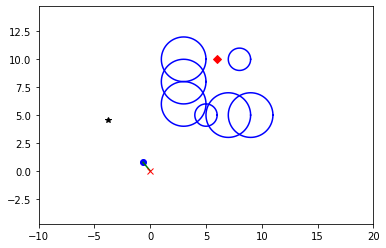

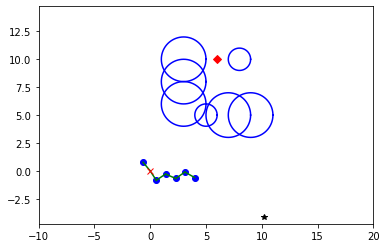

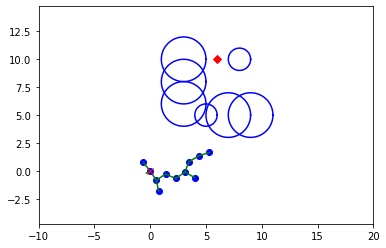

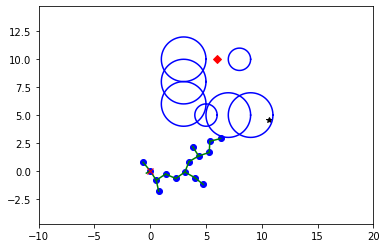

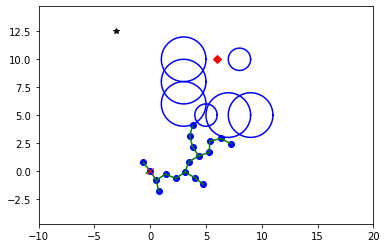

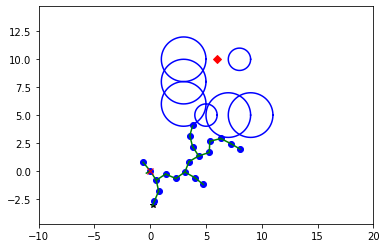

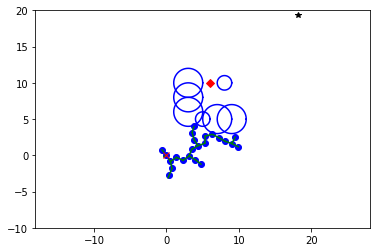

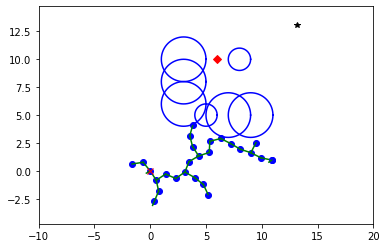

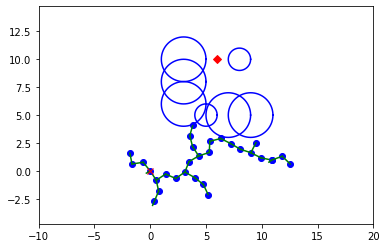

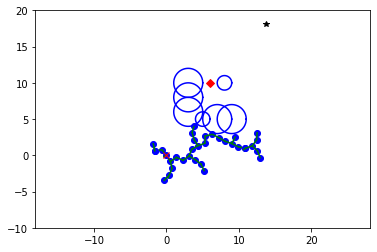

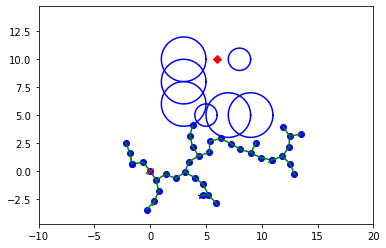

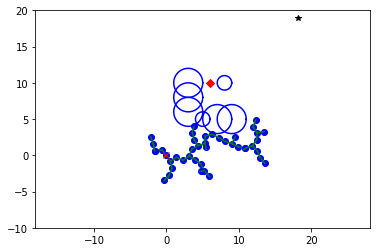

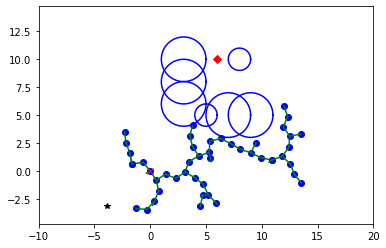

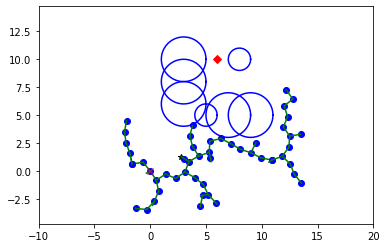

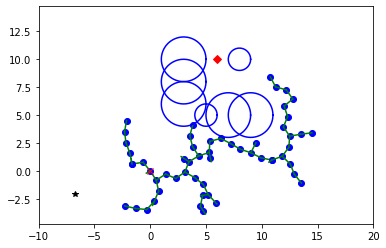

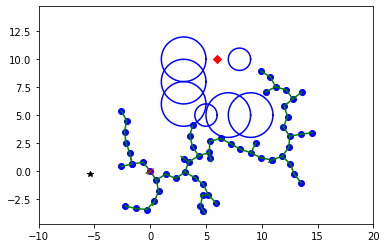

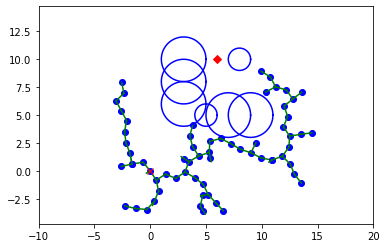

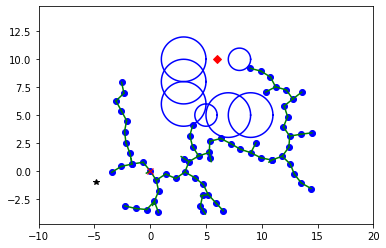

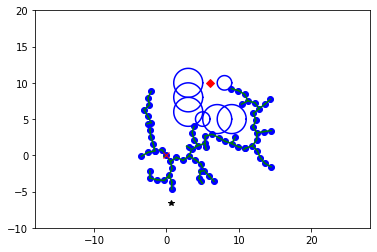

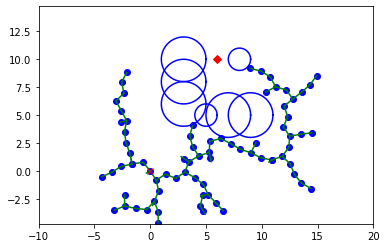

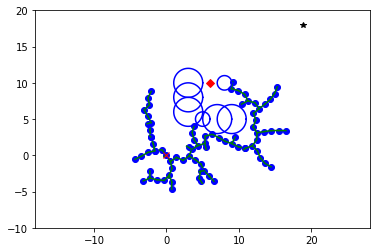

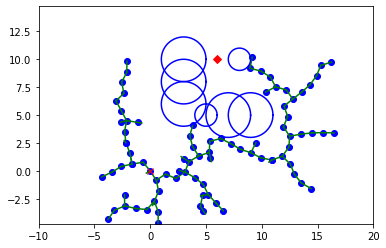

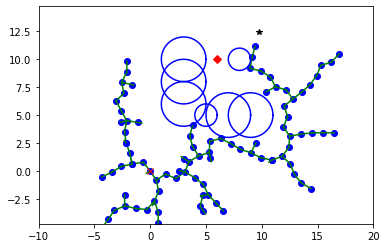

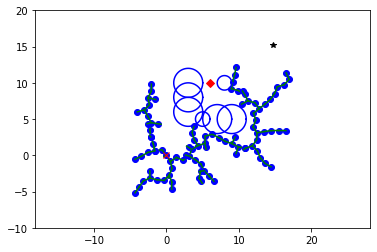

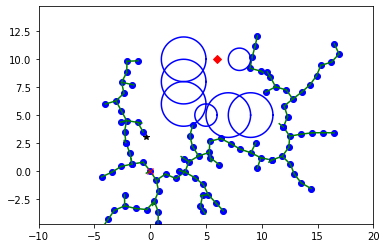

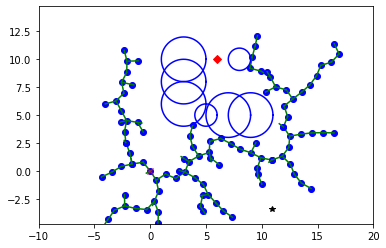

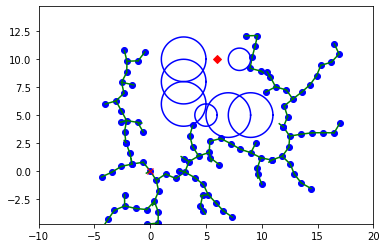

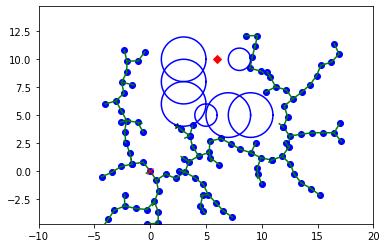

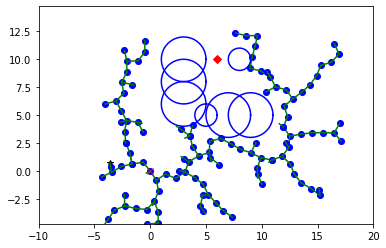

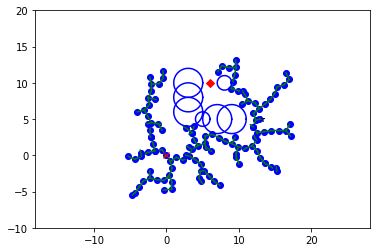

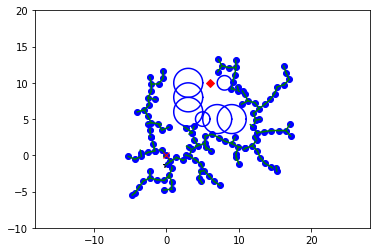

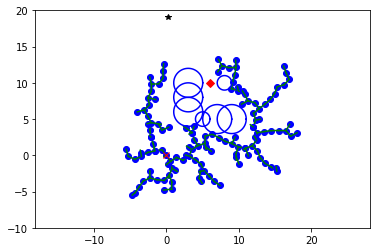

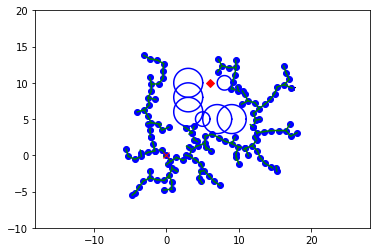

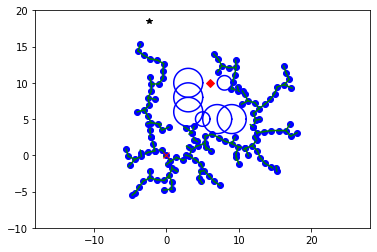

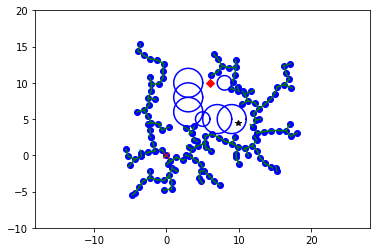

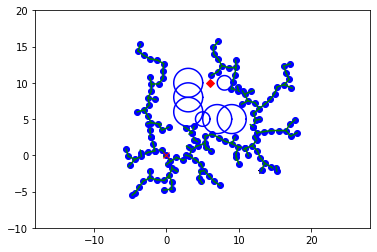

found path!!


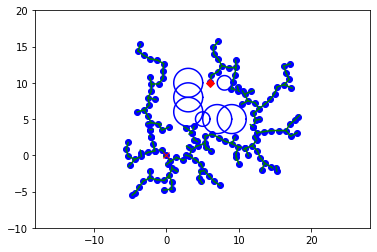

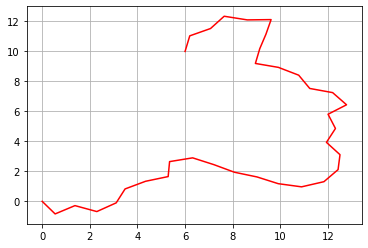

In [3]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np

show_animation = True
class RRT:

    class Node:

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    def __init__(self, start, goal, obstacle_list, rand_area,
                 expand_dis=1.0, path_resolution=0.5, goal_sample_rate=1, max_iter=1500):
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.tree = []

    def planning(self, animation=True):
        self.tree = [self.start]
        for i in range(self.max_iter):
            #1. 랜덤 노드를 뽑고
            rnd_node = self.get_random_node()

            #2. 랜덤 노드로부터 가장 가까운 노드를 선택해서
            nearest_ind = self.get_nearest_node_index(self.tree, rnd_node)
            nearest_node = self.tree[nearest_ind]

            #3. 새로운 노드를 선정한다.
            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            #4. 만약 장애물하고 충돌이 나지 않으면 노드를 트리에 추가한다.
            if self.check_collision(new_node, self.obstacle_list):
                self.tree.append(new_node)
            #5 추가된 노드를 그려줍니다.
            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            # 목표 지점을 찾았는지 확인
            if self.calc_dist_to_goal(self.tree[-1].x, self.tree[-1].y) <= self.expand_dis:
                final_node = self.steer(self.tree[-1], self.end, self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    return self.generate_final_course(len(self.tree) - 1)


        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):
        new_node = self.Node(from_node.x, from_node.y)

        #시작 좌표(from_node) 와 (끝 좌표)to_node간 각도하고 거리를 계산해줍니다.
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        #[1] 시작 path(from node의 좌표)
        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        #목표치(to node)까지 거리가 너무 길면 짤라줍니다.
        if extend_length > d:
            extend_length = d


        # 방금 위에서 짤라준 목표치까지의 거리를 resol로 나눠서 그릴 path 노드의 개수를 정해줍니다.
        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand): #방금 위에서 정해준 개수만큼
            new_node.x += self.path_resolution * math.cos(theta) #x, y 좌표 정해서
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x) #[1] path에 추가해줍니다.
            new_node.path_y.append(new_node.y)

        #반올림하느라 짤린 거리도 path에 추가해줍니다.
        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)

        #트리 구조여서 parent 지정, 마지막에 Goal을 찾았을 때 트리 구조가 유용하게 쓰입니다.
        new_node.parent = from_node
        return new_node


    # 목표를 찾은 노드부터 parent를 타고 올라가 시작점까지의 path를 생성합니다.
    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.tree[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])
        return path

    #거리 구하는 함수
    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    #랜덤 노드(랜덤 목표점)선정
    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(random.uniform(self.min_rand, self.max_rand),
                            random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    # 그리기 함수
    def draw_graph(self, rnd=None):
        plt.clf()
        # 멈출려면 ESC 키를 누르시면 됩니다.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])

        # 랜덤 노드(랜덤 목표점)를 그립니다. 검은색 별
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "*k")

        # path를 그리는 함수입니다. 초록색 선
        for node in self.tree:
            if node.parent:
                plt.plot(node.x,node.y, 'ob')
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)
        # 출발점과 도착점을 그려주고
        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "Dr")
        plt.axis("equal")
        plt.axis([-10, 20, -10, 20])
      #  plt.grid(True)
        plt.pause(0.001)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)


    # 랜덤 목표 지점으로부터 가장 가까이에 있는 노드를 찾는 함수입니다.
    @staticmethod
    def get_nearest_node_index(tree, rnd_node):
        dlist = [(node.x - rnd_node.x) ** 2 + (node.y - rnd_node.y)
                 ** 2 for node in tree]
        minind = dlist.index(min(dlist))

        return minind

    # 랜덤 목표 지점으로부터 가장 가까이에 있는 노드를 찾는 함수입니다.
    @staticmethod
    def check_collision(node, obstacleList):

        if node is None:
            return False
        # 제일 가까운 노드를 찾습니다.
        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= size ** 2:
                return False  # collision

        return True  # safe

    #거리, 각도 계산
    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta


def main(gx=6.0, gy=10.0):
    print("start " + '__file__')
    # ====Search Path with RRT====
    obstacleList = [
        (5, 5, 1),
        (3, 6, 2),
        (3, 8, 2),
        (3, 10, 2),
        (7, 5, 2),
        (9, 5, 2),
        (8, 10, 1)
    ]  # [x, y, radius]
    # Set Initial parameters
    rrt = RRT(start=[0, 0],
              goal=[gx, gy],
              rand_area=[-7, 20],
              obstacle_list=obstacleList)
    path = rrt.planning(animation=show_animation)

    if path is None:
        print("Cannot find path")
    else:
        print("found path!!")

        # Draw final path
        if show_animation:
            rrt.draw_graph()
            plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
            plt.grid(True)
            plt.pause(0.01)  # Need for Mac
            plt.show()


if __name__ == '__main__':
    main()